In [13]:
library("dplyr")
library("readr")
library("tidyverse")
library("astsa")

options(repr.plot.width=12, repr.plot.height=7) #ajusta tamaño de graficas


# Obligatorio - Series Temporales
## Análisis de incendios en Brasil (1998-2017)
### Nicolás Eiris - Ignacio Fiori - Sebastián Otte

In [14]:
df = read_csv(
 "amazon.csv", 
 col_types = cols(
   month = col_factor(
           levels = c("Janeiro", "Fevereiro",  
                      parse_character("Mar\xe7o", locale = locale(encoding = "ISO-8859-1")), 
                      "Abril", "Maio", "Junho", "Julho", "Agosto", "Setembro", 
                      "Outubro", "Novembro", "Dezembro")), 
   state = col_factor(levels = c("Acre", "Alagoas", "Amapa", 
                                 "Amazonas", "Bahia", "Ceara", 
                                 "Distrito Federal", "Espirito Santo", 
                                 "Goias", "Maranhao", "Mato Grosso", 
                                 "Minas Gerais", 
                                 parse_character("Par\xe1", 
                                                 locale = locale(encoding = "ISO-8859-1")), 
                                 "Paraiba", "Pernambuco", "Piau", "Rio", "Rondonia", 
                                 "Roraima", "Santa Catarina", "Sao Paulo", 
                                 "Sergipe", "Tocantins")),
   date = col_date(format = "%Y-%m-%d"),
   year = col_factor(levels = c("1998", "1999", "2000", "2001", "2002", "2003","2004",
                                "2005", "2006", "2007", "2008","2009", "2010", "2011", 
                                "2012", "2013", "2014", "2015", "2016", "2017"))
   ), 
 locale = locale(encoding = "ISO-8859-1", grouping_mark = "." ))

In [15]:
head(df)

year,state,month,number,date
<fct>,<fct>,<fct>,<dbl>,<date>
1998,Acre,Janeiro,0,1998-01-01
1999,Acre,Janeiro,0,1999-01-01
2000,Acre,Janeiro,0,2000-01-01
2001,Acre,Janeiro,0,2001-01-01
2002,Acre,Janeiro,0,2002-01-01
2003,Acre,Janeiro,10,2003-01-01


##### Parse date from year & month

In [16]:
parse_date = function(row) {
    year = row["year"]
    month = row["month"]
    month_num = -1
    if (month == "Janeiro") {
        month_num = "01" 
    } else if (month == "Fevereiro") {
        month_num = "02"
    } else if (month == "Março") {
        month_num = "03"
    } else if (month == "Abril") {
        month_num = "04"
    } else if (month == "Maio") {
        month_num = "05"
    } else if (month == "Junho") {
        month_num = "06"
    } else if (month == "Julho") {
        month_num = "07"
    } else if (month == "Agosto") {
        month_num = "08"
    } else if (month == "Setembro") {
        month_num = "09"
    } else if (month == "Outubro") {
        month_num = "10"
    } else if (month == "Novembro") {
        month_num = "11"
    } else if (month == "Dezembro") {
        month_num = "12"
    }
    paste(year, month_num, "01",sep="-")
}
df$date = apply(df, 1, parse_date)
head(df)

year,state,month,number,date
<fct>,<fct>,<fct>,<dbl>,<chr>
1998,Acre,Janeiro,0,1998-01-01
1999,Acre,Janeiro,0,1999-01-01
2000,Acre,Janeiro,0,2000-01-01
2001,Acre,Janeiro,0,2001-01-01
2002,Acre,Janeiro,0,2002-01-01
2003,Acre,Janeiro,10,2003-01-01


#### Keep target & date columns

In [18]:
brasil = df %>%
  group_by(year, month) %>%
  summarise(number = sum(number))

brasil$date = apply(brasil, 1, parse_date)
brasil

`summarise()` has grouped output by 'year'. You can override using the `.groups` argument.



year,month,number,date
<fct>,<fct>,<dbl>,<chr>
1998,Janeiro,0,1998-01-01
1998,Fevereiro,0,1998-02-01
1998,Março,0,1998-03-01
1998,Abril,0,1998-04-01
1998,Maio,0,1998-05-01
1998,Junho,3551,1998-06-01
1998,Julho,8066,1998-07-01
1998,Agosto,35549,1998-08-01
1998,Setembro,41968,1998-09-01


In [19]:
brasil = brasil[, c("date", "number")]

In [21]:
brasil <- brasil[order(brasil$date),]

In [22]:
brasil_ts <- ts(brasil$number, 
            start=c(1998, 1), 
            end=c(2017, 11),
            frequency = 12)
print(brasil_ts)

        Jan    Feb    Mar    Apr    May    Jun    Jul    Aug    Sep    Oct
1998      0      0      0      0      0   3551   8066  35549  41968  23495
1999   1081   1284    667    717   1812   3632   8756  38415  36913  27012
2000    778    561    848    537   2097   6275   4739  22202  22319  24321
2001    547   1059   1268   1081   2090   8433   6490  31887  32193  31038
2002   1654   1570   1679   1682   3818  10839  13751  55099  49566  47722
2003   5091   2398   2749   2677   1747   6506  11804  37382  55913  43295
2004   2705   1255   2040   1335   3535  14262  23809  48038  70531  36002
2005   4990   2153   1706   1011   3210   5811  15663  39912  74574  49876
2006   3255   1666   1774    792    808   1968   5722  29443  41264  21854
2007   3055   1751   2136    415   1286   3956   6197  66837  78299  27911
2008   2125   1275   1239   1253    553   1287   4507  14528  35836  37617
2009   2848   1140   1392   1078   2593   2962   6599  15534  25002  24202
2010   2851   2386   2417

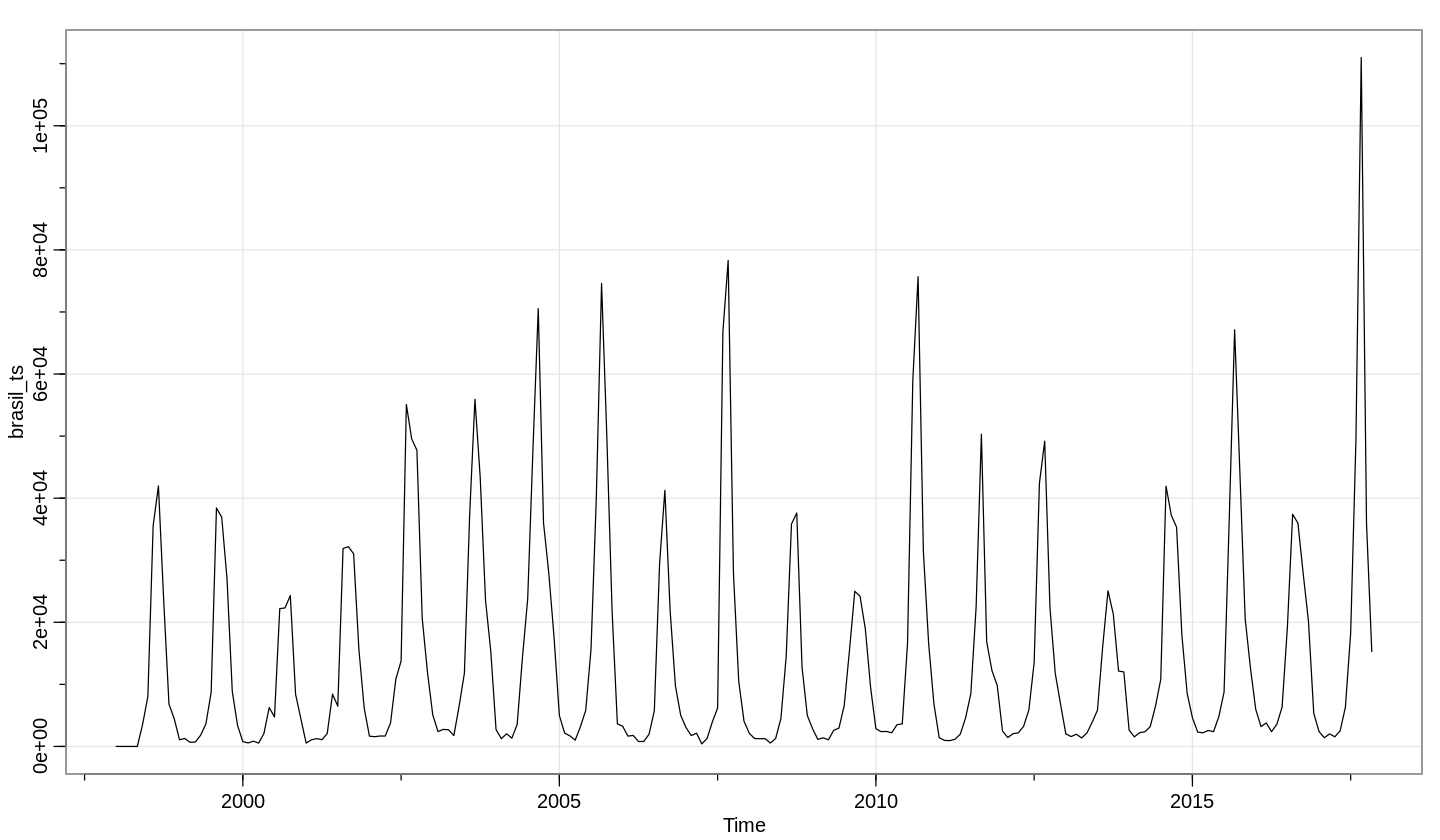

In [27]:
tsplot(brasil_ts)

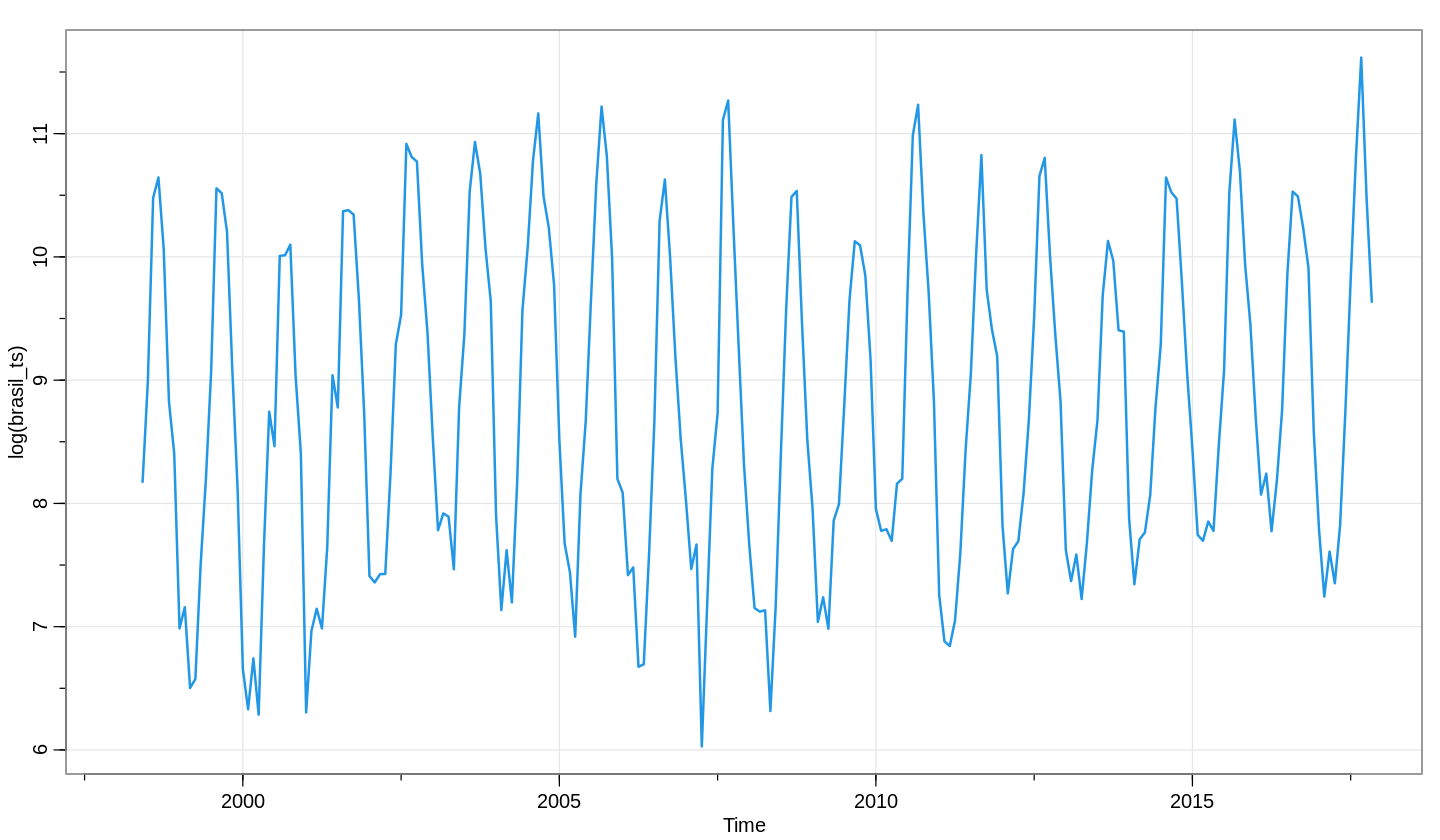

In [33]:
tsplot(log(brasil_ts), col=4, lwd=2)

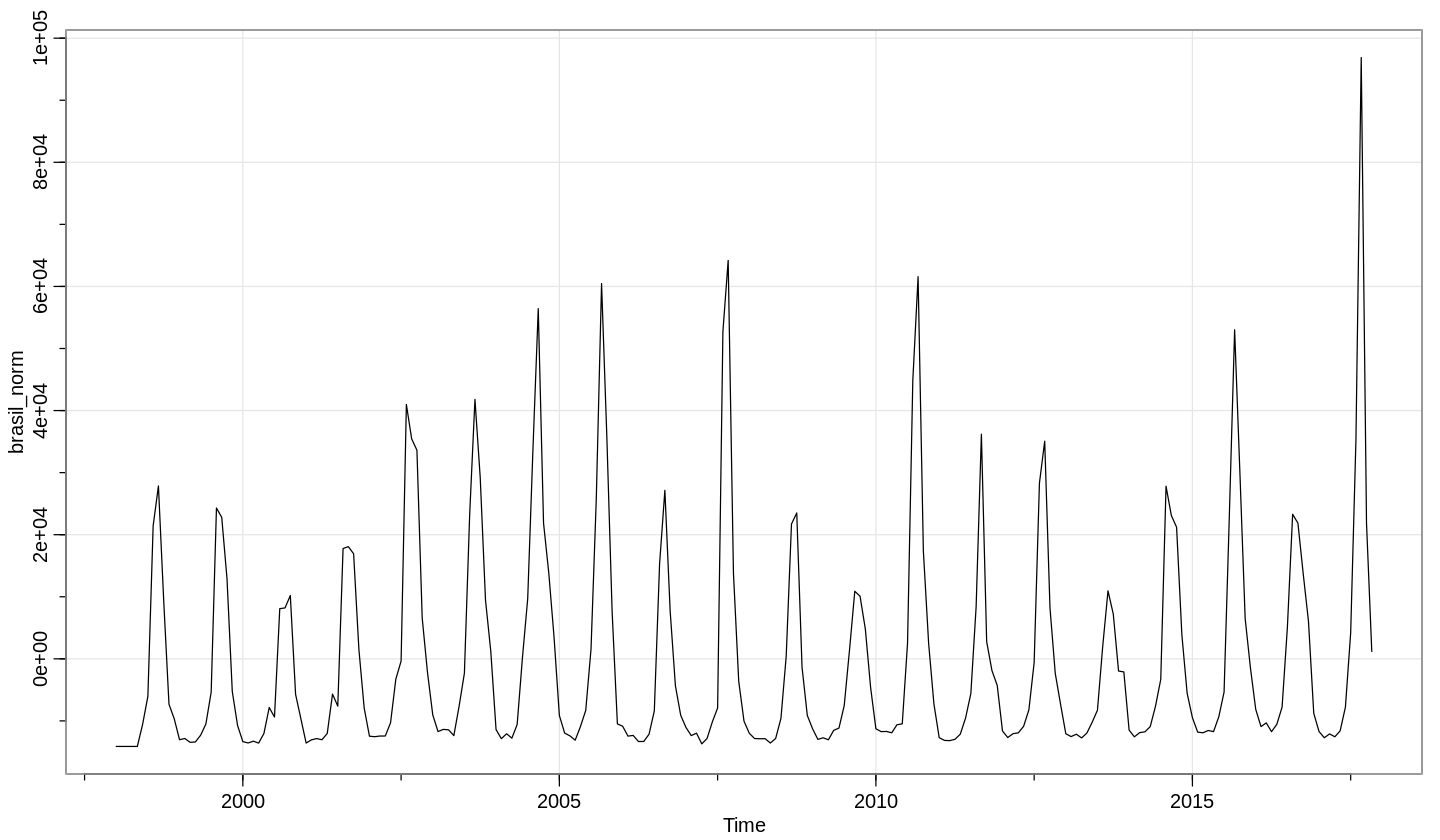

In [29]:
brasil_norm = brasil_ts - mean(brasil_ts)
tsplot(brasil_norm)

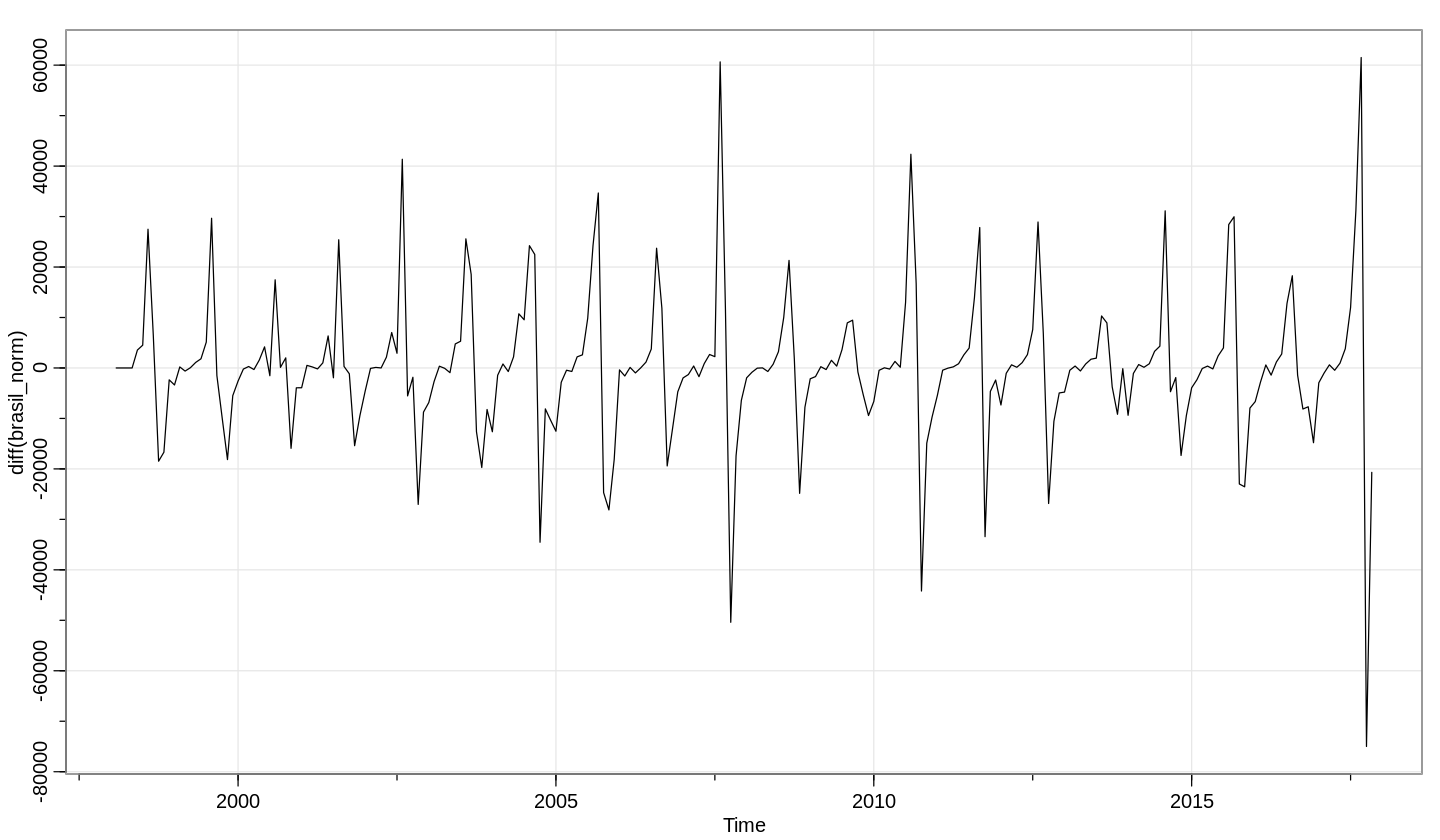

In [31]:
tsplot(diff(brasil_norm))